<a href="https://colab.research.google.com/github/mainedtayag/Tech_Exam/blob/main/Wind_Power_MaineTayag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# Load datasets
loc1 = pd.read_csv("https://raw.githubusercontent.com/mainedtayag/Tech_Exam/0d8e65f15cd7a7250655073a769a457fb99dcce9/Location1.csv")
loc2 = pd.read_csv("https://raw.githubusercontent.com/mainedtayag/Tech_Exam/0d8e65f15cd7a7250655073a769a457fb99dcce9/Location2.csv")
loc3 = pd.read_csv("https://raw.githubusercontent.com/mainedtayag/Tech_Exam/0d8e65f15cd7a7250655073a769a457fb99dcce9/Location3.csv")
loc4 = pd.read_csv("https://raw.githubusercontent.com/mainedtayag/Tech_Exam/0d8e65f15cd7a7250655073a769a457fb99dcce9/Location4.csv")

In [ ]:
loc1.shape

(43800, 10)

In [ ]:
# Check if column name matches row value
loc1.head()

,Time,temperature_2m,relativehumidity_2m,dewpoint_2m,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,Power
0,2017-01-02 00:00:00,28.5,85,24.5,1.44,1.26,146,162,1.4,0.1635
1,2017-01-02 01:00:00,28.4,86,24.7,2.06,3.99,151,158,4.4,0.1424
2,2017-01-02 02:00:00,26.8,91,24.5,1.30,2.78,148,150,3.2,0.1214
3,2017-01-02 03:00:00,27.4,88,24.3,1.30,2.69,58,105,1.6,0.1003
4,2017-01-02 04:00:00,27.3,88,24.1,2.47,4.43,58,84,4.0,0.0793


In [ ]:
# Check data type
loc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43800 entries, 0 to 43799
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Time                 43800 non-null  object 
 1   temperature_2m       43800 non-null  float64
 2   relativehumidity_2m  43800 non-null  int64  
 3   dewpoint_2m          43800 non-null  float64
 4   windspeed_10m        43800 non-null  float64
 5   windspeed_100m       43800 non-null  float64
 6   winddirection_10m    43800 non-null  int64  
 7   winddirection_100m   43800 non-null  int64  
 8   windgusts_10m        43800 non-null  float64
 9   Power                43800 non-null  float64
dtypes: float64(6), int64(3), object(1)
memory usage: 3.3+ MB


In [ ]:
# Check for Null Values
loc1.isnull().sum()

,0
Time,0
temperature_2m,0
relativehumidity_2m,0
dewpoint_2m,0
windspeed_10m,0
windspeed_100m,0
winddirection_10m,0
winddirection_100m,0
windgusts_10m,0
Power,0


In [ ]:
# Cast Time col to datetime
loc1['Time']=pd.to_datetime(loc1['Time'])

# Create column for Year, Month, Quarter, Day and Hour
loc1['Year']=loc1['Time'].dt.year
loc1['Month']=loc1['Time'].dt.month
loc1['Quarter']=loc1['Time'].dt.quarter
loc1['Day']=loc1['Time'].dt.dayofweek
loc1['Hour']=loc1['Time'].dt.time

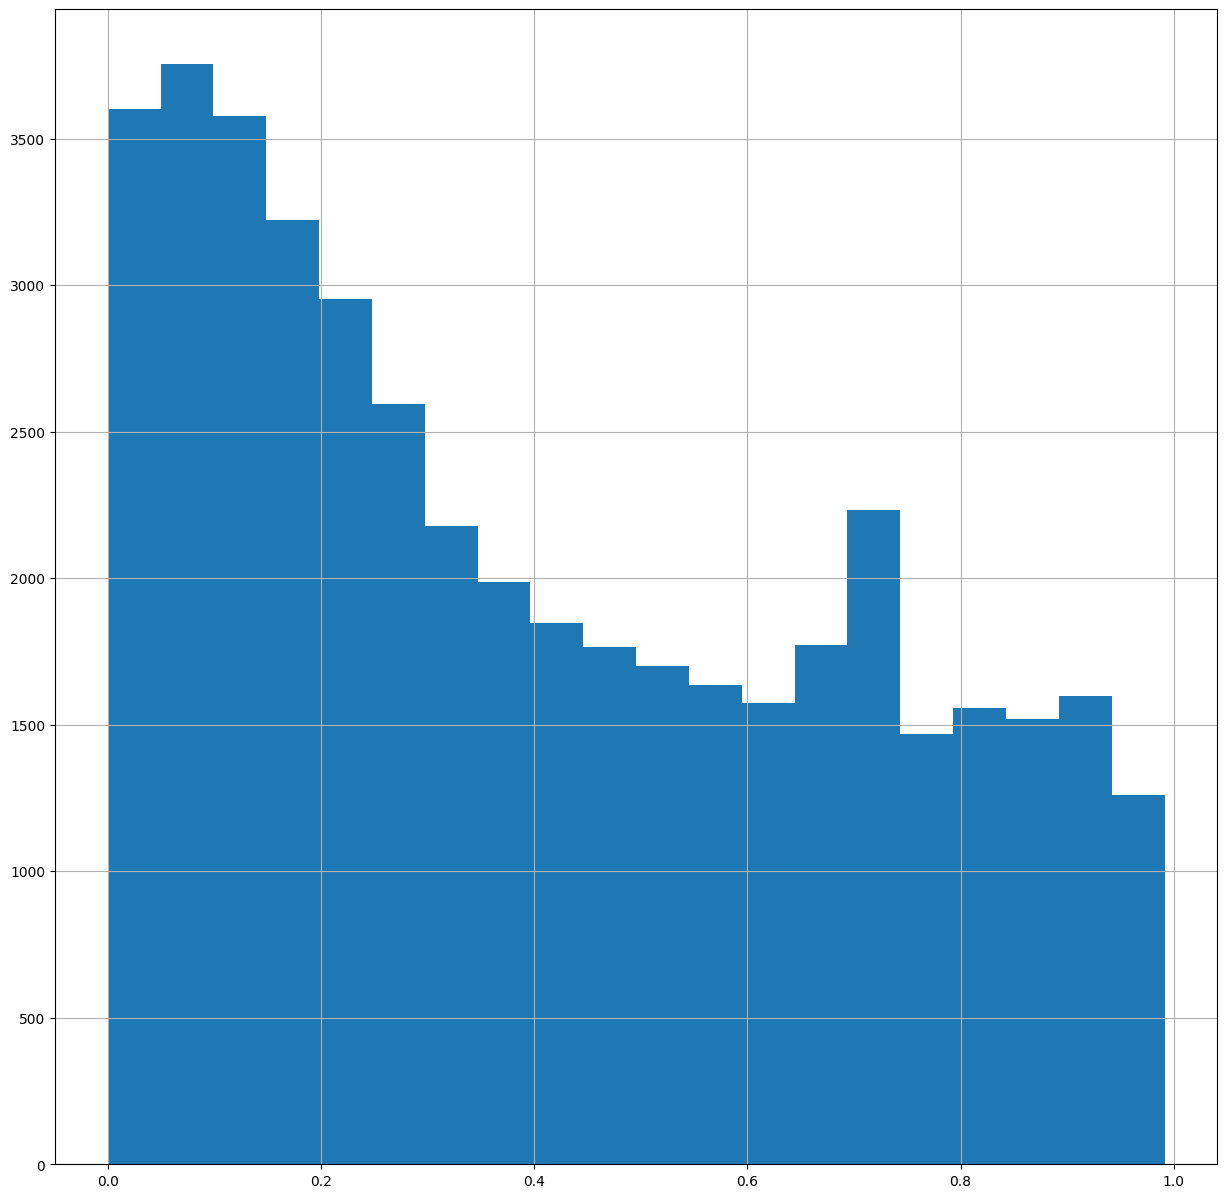

In [ ]:
loc1['Power'].hist(bins=20, figsize=(15, 15))
plt.show()

The distribution of power is positively skewed suggesting an intermittent power generation.

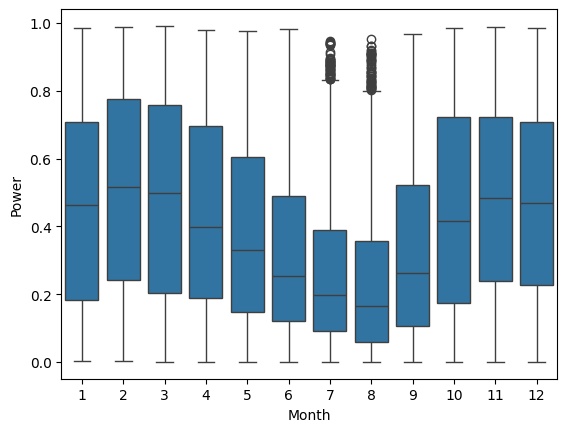

In [ ]:
sns.boxplot(x="Month", y="Power", data=loc1)
plt.xlabel("Month")
plt.ylabel("Power")
plt.show()

Power distribution is usually high during the month of February and March but continue to decline until August.

Power                  1.000000
windspeed_100m         0.778704
windspeed_10m          0.732801
windgusts_10m          0.662677
winddirection_100m     0.171619
winddirection_10m      0.157623
Year                  -0.001057
Time                  -0.011625
Day                   -0.026326
Hour                  -0.042698
Month                 -0.056100
Quarter               -0.058847
relativehumidity_2m   -0.070360
temperature_2m        -0.207101
dewpoint_2m           -0.223739
Name: Power, dtype: float64


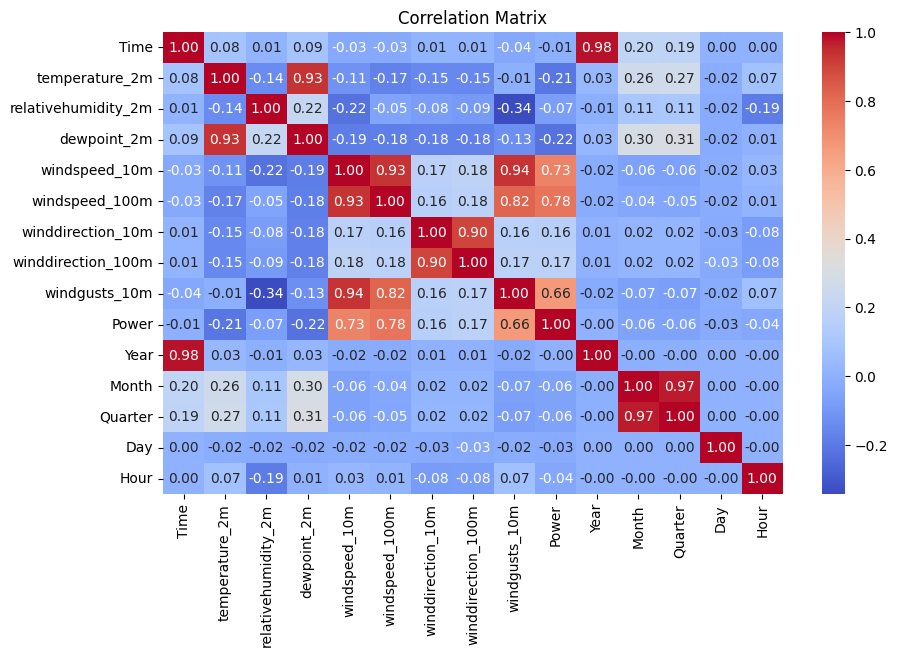

In [ ]:
# checking feature importance using correlation
loc1['Hour'] = loc1['Time'].dt.hour

corr = loc1.corr()

print(corr['Power'].sort_values(ascending=False))

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

windspeed_100m, windspeed_10m, and windgusts_10m are clearly the most predictive of Power which makes sense as we are analyzing Power Data from wind turbines, Power output is dependent on wind speed.

Also, variables with higher feature importance contribute more to predicting Power.

In [ ]:
features = [
    'windspeed_10m',
    'windspeed_100m',
    'windgusts_10m',
    'winddirection_10m',
    'winddirection_100m',
    'temperature_2m',
    'relativehumidity_2m',
    'dewpoint_2m',
    'Year',
    'Month',
    'Quarter',
    'Day',
    'Hour'
]
target = 'Power'

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(loc1[features], loc1[target])

# Predict expected Power
loc1['Expected_Power'] = rf.predict(loc1[features])\
loc1['Lost_Power_kW'] = np.maximum(loc1['Expected_Power'] - loc1['Power'], 0)
loc1['Lost_Energy_MWh'] = loc1['Lost_Power_kW'] / 1000  # for 1-hour intervals

# Total energy lost
total_lost_MWh = loc1['Lost_Energy_MWh'].sum()
print(f"Estimated total lost energy during anomalous periods: {total_lost_MWh:.2f} MWh")

Estimated total lost energy during anomalous periods: 0.79 MWh


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

target = "Power"
features = [
    'windspeed_10m',
    'windspeed_100m',
    'windgusts_10m',
    'winddirection_10m',
    'winddirection_100m',
    'temperature_2m',
    'relativehumidity_2m',
    'dewpoint_2m',
    'Year',
    'Month',
    'Quarter',
    'Day',
    'Hour'
]

X = loc1[features]
y = loc1[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_split=2, random_state=42, n_jobs=-1)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, preds)


print("RMSE:", rmse)
print("MAE:", mae)
print("R² Score:", r2)

RMSE: 0.1367050487541126
MAE: 0.10025610707762557
R² Score: 0.7741666446113351


The scores indicates a strong model performance. With R^2 Score of 0.77 and low RMSE indicates that the Random Forest is well-fitted to the data.

In [ ]:
importances = pd.Series(model.feature_importances_, index=features)
print("\nFeature Importances:")
print(importances.sort_values(ascending=False))


Feature Importances:
windspeed_100m         0.689764
dewpoint_2m            0.037177
temperature_2m         0.036467
windgusts_10m          0.033245
Hour                   0.030547
relativehumidity_2m    0.029928
winddirection_100m     0.029030
winddirection_10m      0.028441
windspeed_10m          0.027258
Day                    0.018398
Month                  0.018092
Year                   0.017304
Quarter                0.004349
dtype: float64


Since we are using a Random Forest model, I re-evaluated the feature importance instead of relying on correlation. This time, the top driver in the model is the windspeed_100 column followed by dewpoint_2m, temperature_2m and windgust_10m. windspeed_100 as a top contributor make sense as we are predicting Power generated by wind turbine.

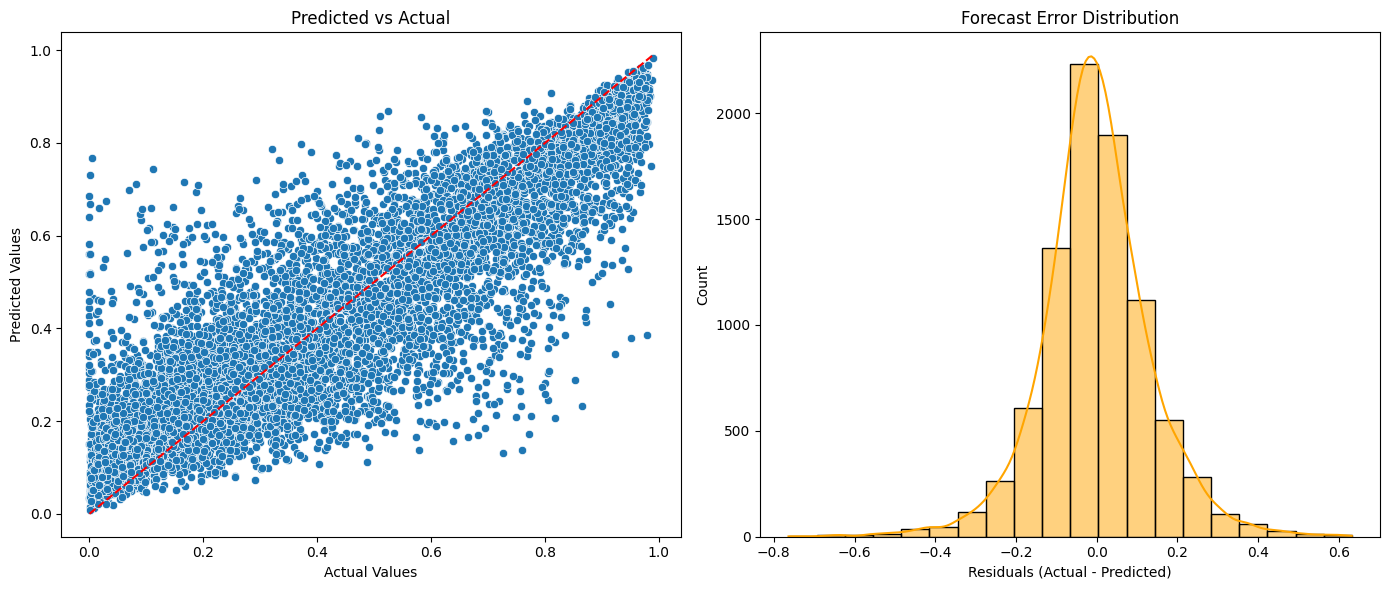

In [ ]:

errors = y_test - y_pred

plt.figure(figsize=(14,6))

# Predicted vs Actual
plt.subplot(1,2,1)
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual")

# Residuals Plot
plt.subplot(1,2,2)
sns.histplot(errors, kde=True, bins=20, color='orange')
plt.xlabel("Residuals (Actual - Predicted)")
plt.title("Forecast Error Distribution")

plt.tight_layout()
plt.show()

Under-predictions, could lead to shortages or missed revenue opportunities.

Over-predictions, could lead to oversupply, higher operational cost and lower revenue.